In [1]:
from utils import *

# Parameters for simulation
env = read_env(jupyter=True)

patientNr = env.patientNr
path = env.path
maxPatient = env.maxPatient
root = env.root
ICR0 = env.ICR0
ndim = env.n_dim
nMeals = env.nMeals


In [9]:
while patientNr < maxPatient:

    files_to_save = dict()

    # historical data
    X_sample = np.array([0,0]).reshape(1,2)
    patient = Sim.Patient(patientNr,target=6)

    patient.steadyState() # compute the basal insulin and steady-state 

    # Simulate statedy state to obtain Y_sample
    patient.simulate(X_sample[0][0],X_sample[0][1],x0 = patient.xSS)
    Y_sample = patient.CGP.reshape((1,1))

    # Preallocate memory
    nTAR = np.zeros(nMeals)
    nTIR = np.zeros(nMeals)
    nTBR = np.zeros(nMeals)
    nMeal = np.zeros(nMeals)
    nBG0 = np.zeros(nMeals)

    nCGM = np.zeros((nMeals, patient.nSim))
    nCGP = np.zeros((nMeals, patient.nSim))

    xinit = patient.xSS

    # Run 1 iteration of Doctor's algorithm as preparation
    patient.ICR = ICR0
    Meal = np.array([10]).reshape((1,1))
    Bolus = Meal/patient.ICR

    patient.simulate(Bolus,Meal,x0 = patient.xSS, kappa = 100)
    e = (patient.CGM[-1] - patient.target)/patient.ISF * 200# Convert to correct units mU/min! 1000/5
    patient.ICR = ((Meal * patient.ICR)/(patient.ICR * e + Meal)).item()

    var_uni = 1/12 * (20 - 5)**2
    mu = 25 # Set it to this to scale to correct units
    m = 1/patient.ICR
    delta = 0.05
    
    mi = [m]

    for i in tqdm(range(nMeals), desc = f'Running simulation for patientNr: {patientNr}'):
        np.random.seed(int(i+75))

        Meal = np.random.uniform(5,20, size = (1,1))

        Bolus = Meal * m
        
        patient.simulate(Bolus,Meal,x0 = patient.xSS, kappa = 100)

        X_next = np.array([Bolus.squeeze(), Meal.squeeze()]).reshape(1,ndim)
        Y_next = patient.CGP 
        xinit = patient.xEnd
        
        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.vstack((Y_sample, Y_next))

        # Other things to save
        CGMi = patient.CGM
        x = np.where(CGMi<=3.9)
        y = np.where(CGMi>10)
        TAR = len(y[0])/len(CGMi)*100
        TBR = len(x[0])/len(CGMi)*100
        TIR = 100 - TAR - TBR

        # Now fix the doctor update formula
        e = patient.CGM[-1] - patient.target

        m = m + mu/(Meal.item() * Meal.item() + delta) * e * Meal.item()
        
        mi.append(m)


        nTAR[i] = TAR
        nTIR[i] = TIR
        nTBR[i] = TBR
        nMeal[i] = Meal
        nCGM[i,:] = CGMi
        nCGP[i,:] = patient.CGP
        nBG0[i] = xinit[10]
    
    # Save after simulation is done
    files_to_save['nTAR'] = nTAR
    files_to_save['nTIR'] = nTIR
    files_to_save['nTBR'] = nTBR
    files_to_save['nMeal'] = nMeal
    files_to_save['nCGM'] = nCGM
    files_to_save['nCGP'] = nCGP
    files_to_save['nBG0'] = nBG0
    files_to_save['X_sample'] = X_sample
    files_to_save['Y_sample'] = Y_sample

    save_files(files_to_save, path=path, patientNr=patientNr)
    # load last patient
    patientNr = update_lastPatient(path, maxPatient)


Running simulation for patientNr: 138:  96%|█████████▌| 192/200 [00:26<00:01,  7.38it/s]


KeyboardInterrupt: 

In [ ]:
# Check if simulation is done
if simulation_is_done(path, maxPatient):
    preprocess_simulation_data(path) # preprocess output of all simulations

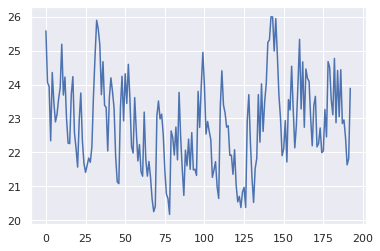

In [10]:
plt.plot(mi)